<a href="https://colab.research.google.com/github/pablex72/splines-approx-fit/blob/main/splines_approx_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import math as mt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score


class PsplinesClf(BaseEstimator, ClassifierMixin):
    """ A classifier which implements a penalized spline approach to classification
    problems. 
    For more information regarding penalized splines we refer to
    
    Parameters
    ----------
    smoothing : float, default = 1
        A penalty parameter that determines the amount of smoothing applied to
        the spline bases.
    ndx : int, default = 5
        The number of basis functions
    deg : int, default = 2
        Degree of the spline functions
    pord : int, default = 2
        Degree of the difference matrix
    min : float, default = None
    max : float, default = None
    max_iter : int, maximum number of iterations
    Attributes
    ----------
    X_ : ndarray, shape (n_samples, n_features)
        The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
        The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
        The classes seen at :meth:`fit`.
    """
 
    def __init__(self, smoothing = 1, ndx = 5, deg = 2, pord = 2, min = None, max = None, max_iter = 35):
        ''' Constructor for this class. '''
        self.ndx = ndx
        self.deg = deg
        self.pord = pord
        self.smoothing = smoothing
        self.max = max
        self.min = min
        self.max_iter = max_iter



    def fit(self, X, y):
        """A reference implementation of a fitting function for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        X = X[:,0]
        # Store the classes seen during fit
        max_iter = self.max_iter
        self.classes_ = unique_labels(y)
        min = np.min(X)
        max = np.max(X)
        ndx = self.ndx
        deg = self.deg
        pord = self.pord
        smoothing = self.smoothing
        dx = (max - min)/ndx
        knots = np.arange(min - deg*dx,max+dx+ deg*dx,dx)
        sub = np.subtract.outer(X,knots)

        P = np.where(sub>0,sub**deg,0)
        n = P.shape[1]
        D = np.diff(np.eye(n),deg+1)/(mt.gamma(deg+1)*dx**deg)
        B = (-1)**(deg + 1)*np.dot(P,D)
        # append bbase B with penalty n changes here
        n = B.shape[1]
        pen = np.sqrt(smoothing)*np.diff(np.eye(n),pord)
        pen = np.transpose(pen)
        yappend = np.array([0]*(n - pord))
        wappend = np.array([1]*(n - pord))
        
        iter1 = 0
        nobs = len(y)
        znew = np.array([0]*nobs)
        z = np.array([1]*nobs)
        while iter1 < max_iter:
           iter1 = iter1 + 1
           dz = np.abs(z - znew)
           if(np.max(dz) < 1e-5):
             break
           z = znew
           prob = 1/(1 + np.exp(-z))
           w = prob*(1 - prob)
           u = (y - prob) / w + z
           u = np.concatenate((u,yappend), axis=0)
           expl = np.concatenate((B,pen), axis=0)
           W = np.concatenate((w,wappend), axis=0)
           W = np.sqrt(W)
           Aw = expl*np.array(W)[:, np.newaxis] # sweep along the rows
           Bw = W*u
           result = np.linalg.lstsq(Aw,Bw,rcond=None)
           beta = result[0]
           znew = np.dot(B,beta)

        self.max = max
        self.min = min
        self.beta_ = beta
        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):
        """ A reference implementation of a prediction for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the prediction that is made
            for this sample.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # Input validation
        X = check_array(X)

        X = X[:,0]
        min = self.min
        max = self.max
        ndx = self.ndx
        deg = self.deg
        pord = self.pord
        smoothing = self.smoothing
        dx = (max - min)/ndx
        knots = np.arange(min - deg*dx,max+dx+ deg*dx,dx)
        sub = np.subtract.outer(X,knots)
        P = np.where(sub>0,sub**deg,0)
        n = P.shape[1]
        D = np.diff(np.eye(n),deg+1)/(mt.gamma(deg+1)*dx**deg)
        B = (-1)**(deg + 1)*np.dot(P,D)
        pred = np.dot(B,self.beta_)
        self.pred = np.where(pred > 0.0, 1, 0)
        return self.pred
    
    def predict_proba(self, X):
        """ A reference implementation of a prediction probability for a
        classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns the probability of the sample for each class in the model.
         """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        X = X[:,0]
        min = self.min
        max = self.max
        ndx = self.ndx
        deg = self.deg
        pord = self.pord
        smoothing = self.smoothing
        dx = (max - min)/ndx
        knots = np.arange(min - deg*dx,max+dx+ deg*dx,dx)
        sub = np.subtract.outer(X,knots)
        P = np.where(sub>0,sub**deg,0)
        n = P.shape[1]
        D = np.diff(np.eye(n),deg+1)/(mt.gamma(deg+1)*dx**deg)
        B = (-1)**(deg + 1)*np.dot(P,D)

        # Input validation
        # X = check_array(X)

        pred = np.dot(B,self.beta_)
        self.pred = 1/(1+np.exp(-pred))
        return self.pred

    def score(self, X, y, sample_weight=None):
        """Returns the mean accuracy on the given test data and labels.
        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.
        Parameters
        ----------
        X : array-like, shape = (n_samples, n_features)
            Test samples.
        y : array-like, shape = (n_samples) or (n_samples, n_outputs)
            True labels for X.
        sample_weight : array-like, shape = [n_samples], optional
            Sample weights.
        Returns
        -------
        score : float
            Mean accuracy of self.predict(X) wrt. y.
        """
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

In [7]:
#from template_classy import PsplinesClf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier


0.7047451669595782
0.7223198594024605


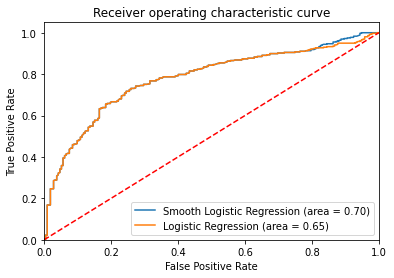

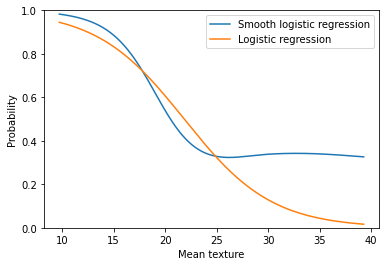

In [8]:
#
# loading sci-kit learn internal data
#
X,y = load_breast_cancer(return_X_y=True)
x = X[:,1]
x = x.reshape(-1, 1)
model = PsplinesClf(ndx=40, smoothing = 1000) #1,10,100,1000,10000
model.fit(x,y)

#
# logistic regression for comparison
#
clf = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs' ))

# Fit it to the training data
clf.fit(x, y)
print(clf.score(x,y))
print(model.score(x,y))

logit_roc_auc = roc_auc_score(y, model.predict(x))
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(x))
logit_roc_auc1 = roc_auc_score(y, clf.predict(x))
fpr1, tpr1, thresholds1 = roc_curve(y, clf.predict_proba(x)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Smooth Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % logit_roc_auc1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#
# plot of smooth curve
#
x = np.linspace(np.min(x),np.max(x),600)
x = x.reshape(-1, 1)
pred = model.predict_proba(x)
plt.plot(x,pred,label="Smooth logistic regression")
lr_pred = clf.predict_proba(x)
plt.plot(x,lr_pred[:,1],label="Logistic regression")
plt.ylim(0, 1)
plt.ylabel('Probability')
plt.xlabel('Mean texture')
plt.legend(loc="best")
plt.show()